#Imports and functions

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('bmh')

%config InlineBackend.figure_format = 'svg'

In [ ]:
def plot_target_distribution(data, transformation):
  f= plt.figure(figsize=(12,4))
  ax=f.add_subplot(121)
  sns.distplot(data,bins=50,ax=ax)
  ax.set_title(f'Distribution of target, transformation: {transformation}')


def find_limits(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  return lower_limit, upper_limit


def find_outliers(data, lower_limit, upper_limit):
  return data[data > upper_limit] + data[data < lower_limit]


def create_hist_with_outliers(data, lower_limit, upper_limit):
  sns.distplot(x=data, axlabel=data.name).set(title=f'{data.name} distribution')
  plt.axvline(upper_limit, linewidth=1 , color = 'red')
  plt.axvline(lower_limit, linewidth=1 , color = 'red')
  plt.show()


def drop_outliers(data, feature, lower_limit, upper_limit):
  data.drop(data[(data[feature] > upper_limit) | (data[feature] < lower_limit)].index, inplace = True)


def transform_and_drop_outliers(dataset, feature, method):
  if method == 'log':
    dataset[feature] = np.log(dataset[feature])
  elif method == 'sqrt':
    dataset[feature] = np.sqrt(dataset[feature])
  elif method == 'cube root':
    dataset[feature] = dataset[feature] ** (1/3)
  elif method == 'box-cox':
    dataset[feature] = scipy.stats.boxcox(dataset[feature])[0]
  lower_limit, upper_limit = find_limits(dataset[feature])
  drop_outliers(dataset, feature, lower_limit, upper_limit)


def build_regression(reg, X_data, y_data, n_splits):
  tscv = TimeSeriesSplit(n_splits = n_splits)

  rmse = []
  mae = []
  mse = []
  r2 = []

  y_predict = np.NaN
  errors = []

  for train_index, test_index in tscv.split(X_data):
      X_train_cv, X_test_cv = X_data.iloc[train_index], X_data.iloc[test_index]
      y_train_cv, y_test_cv = y_data.iloc[train_index], y_data.iloc[test_index]

      reg.fit(X_train_cv, y_train_cv)

      y_predict = reg.predict(X_test_cv)

      mae.append(metrics.mean_absolute_error(y_test_cv, y_predict))
      mse.append(metrics.mean_squared_error(y_test_cv, y_predict))
      r2.append(metrics.r2_score(y_test_cv, y_predict))
      rmse.append(metrics.mean_squared_error(y_test_cv, y_predict, squared=False))

  mae.append(sum(mae) / len(mae))
  mse.append(sum(mse) / len(mse))
  r2.append(sum(r2) / len(r2))
  rmse.append(sum(rmse) / len(rmse))

  print('Score: ', reg.score(X_test_cv, y_test_cv))

  sns.scatterplot(y_test_cv, y_predict).set(title='Actual vs. Predicted')
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')
  plt.show()

  errors = y_test_cv - y_predict

  sns.scatterplot(y_predict,errors, color='r').set(title='Residual')
  plt.xlabel('Predicted values')
  plt.ylabel('Errors')
  plt.show()

  return pd.DataFrame((mae, mse, r2, rmse), index=['MAE', 'MSE', 'R2', 'RMSE'])

#EDA and Data preparation

##Feature description:
Description for the dataset:https://archive.ics.uci.edu/ml/datasets/Air+Quality#

0 `Date:` Date (DD/MM/YYYY)

1 `Time`: Time (HH.MM.SS)

2 `CO(GT)` True hourly averaged concentration CO in mg/m^3 (reference analyzer)

3 `PT08.S1(CO)`: PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)

4 `NMHC(GT)`: True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

5 `C6H6(GT)`: True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

6 `PT08.S2(NMHC)`: PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)

7 `NOx(GT)`: True hourly averaged NOx concentration in ppb (reference analyzer)

8 `PT08.S3(NOx)`: PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

9 `NO2(GT)`: True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

10 `PT08.S4(NO2)`: PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

11 `PT08.S5(O3)`: PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12 `T`: Temperature in  °C

13 `RH`: Relative Humidity (%)

14 `AH`: Absolute Humidity

15 `Unnamed: 15`

16 `Unnamed: 16`

In [ ]:
df = pd.read_csv('/content/AirQualityUCI.csv', sep=';')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
df.shape

(9471, 17)

There are 9471 records and 17 features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


There are non-numerical values for features `CO(GT)`, `C6H6(GT)`, `T`, `RH` and `AH`, so they have object type. Let's convert them to float.

In [ ]:
df['CO(GT)'] = df['CO(GT)'].str.replace(',','.')
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',','.')
df['T'] = df['T'].str.replace(',','.')
df['RH'] = df['RH'].str.replace(',','.')
df['AH'] = df['AH'].str.replace(',','.')

In [ ]:
df[['CO(GT)','C6H6(GT)', 'T','RH','AH']] = df[['CO(GT)','C6H6(GT)', 'T','RH','AH']].astype(float)

I'd like to represent date and time as separate features.

In [ ]:
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [ ]:
df['Hour']=df['Time'].apply(lambda x: str(x)[0:2])
df['Hour']= df['Hour'].apply(lambda x: float(x) if x != 'na' else np.NaN)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Day,Month,Year,Hour
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,...,1268.0,13.6,48.9,0.7578,NaN,NaN,3.0,10.0,2004.0,18.0
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,...,972.0,13.3,47.7,0.7255,NaN,NaN,3.0,10.0,2004.0,19.0
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,...,1074.0,11.9,54.0,0.7502,NaN,NaN,3.0,10.0,2004.0,20.0
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,...,1203.0,11.0,60.0,0.7867,NaN,NaN,3.0,10.0,2004.0,21.0
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,...,1110.0,11.2,59.6,0.7888,NaN,NaN,3.0,10.0,2004.0,22.0


In [ ]:
df.drop(['Date', 'Time'], axis=1 , inplace=True)

In [ ]:
df.dtypes

CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
Unnamed: 15      float64
Unnamed: 16      float64
Day              float64
Month            float64
Year             float64
Hour             float64
dtype: object

We also see that features `Unmamed: 15` and `Unnamed: 16` have 0 non-null values so we can drop them.

In [ ]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1 , inplace=True)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,Month,Year,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3.0,10.0,2004.0,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3.0,10.0,2004.0,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3.0,10.0,2004.0,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3.0,10.0,2004.0,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3.0,10.0,2004.0,22.0


Let's check if there are any missing values.

In [ ]:
df.isnull().sum()

CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Day              114
Month            114
Year             114
Hour             114
dtype: int64

In [ ]:
df[df['C6H6(GT)'].isnull()]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,Month,Year,Hour
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Records in the tail of our dataset are empty so we can drop them.

In [ ]:
df.dropna(how='all',inplace=True)
df.tail()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,Month,Year,Hour
9352,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4.0,4.0,2005.0,10.0
9353,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4.0,4.0,2005.0,11.0
9354,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4.0,4.0,2005.0,12.0
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4.0,4.0,2005.0,13.0
9356,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028,4.0,4.0,2005.0,14.0


In [ ]:
df.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Day              0
Month            0
Year             0
Hour             0
dtype: int64

Now let's look at descriptive statistics.

In [ ]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,Month,Year,Hour
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,15.844181,6.343059,2004.240141,11.498557
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,8.833182,3.465810,0.427192,6.923182
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,1.000000,1.000000,2004.000000,0.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,8.000000,3.000000,2004.000000,5.000000
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,16.000000,6.000000,2004.000000,11.000000
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,23.000000,9.000000,2004.000000,18.000000
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,31.000000,12.000000,2005.000000,23.000000


We know that missing values are marked as `-200`. Let's replace them with NaNs.

In [ ]:
df = df.replace(-200,np.NaN)

Let's see the correlation between features.

In [ ]:
corr = df.corr()
corr['C6H6(GT)'].sort_values(axis=0, ascending=False)

C6H6(GT)         1.000000
PT08.S2(NMHC)    0.981950
CO(GT)           0.931078
NMHC(GT)         0.902559
PT08.S1(CO)      0.883795
PT08.S5(O3)      0.865689
PT08.S4(NO2)     0.765731
NOx(GT)          0.718839
NO2(GT)          0.614474
Hour             0.344169
T                0.198956
AH               0.167972
Month            0.065473
Day              0.010945
RH              -0.061681
Year            -0.132908
PT08.S3(NOx)    -0.735744
Name: C6H6(GT), dtype: float64

Text(0.5, 1.0, 'Correlation')

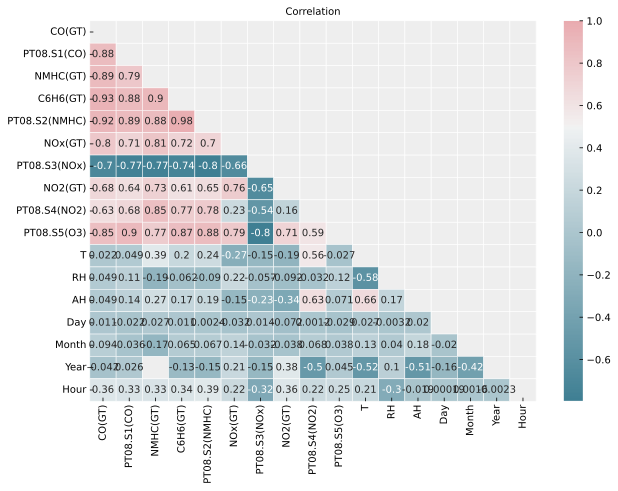

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0.5,
            linewidths=.5,
            annot=True
           )
plt.title("Correlation", fontsize =10)

Here we can see plots of dependencies between target `C6H6(GT)` and other features and plots of some fearures in pairs.

In [ ]:
for i in df.columns.tolist()[2:]:
    sns.lmplot(x=i,y='C6H6(GT)',data=df,markers='.').set(title=f'{i} vs. target')

In [ ]:
sns.pairplot(df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)']])
plt.show()

It seems that a significant part of features correlates with the target. Also we see a large multicollinearity.

##Missing values

Now let's go back to the missing values.

In [ ]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Day                 0
Month               0
Year                0
Hour                0
dtype: int64

We see that some features have the same number of null values.

In [ ]:
df[df['C6H6(GT)'].isnull()]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Day,Month,Year,Hour
524,1.7,NaN,222.0,NaN,NaN,99.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,2004.0,14.0
525,1.9,NaN,197.0,NaN,NaN,108.0,NaN,81.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,2004.0,15.0
526,2.3,NaN,319.0,NaN,NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,2004.0,16.0
701,2.0,NaN,137.0,NaN,NaN,129.0,NaN,106.0,NaN,NaN,NaN,NaN,NaN,4.0,8.0,2004.0,23.0
702,2.4,NaN,189.0,NaN,NaN,154.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN,4.0,9.0,2004.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8111,6.6,NaN,NaN,NaN,NaN,1227.0,NaN,326.0,NaN,NaN,NaN,NaN,NaN,2.0,11.0,2005.0,17.0
8112,6.5,NaN,NaN,NaN,NaN,1061.0,NaN,284.0,NaN,NaN,NaN,NaN,NaN,2.0,11.0,2005.0,18.0
8113,7.1,NaN,NaN,NaN,NaN,1075.0,NaN,289.0,NaN,NaN,NaN,NaN,NaN,2.0,11.0,2005.0,19.0
8114,4.9,NaN,NaN,NaN,NaN,641.0,NaN,215.0,NaN,NaN,NaN,NaN,NaN,2.0,11.0,2005.0,20.0


Since some records are almost empty (including the target) I'll drop them.

In [ ]:
df.dropna(subset=['C6H6(GT)'],inplace=True)

In [ ]:
df.isnull().sum()

CO(GT)           1647
PT08.S1(CO)         0
NMHC(GT)         8104
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
Day                 0
Month               0
Year                0
Hour                0
dtype: int64

In [ ]:
df['NMHC(GT)'].isnull().sum() / len(df['NMHC(GT)'])

0.9013457902346791

The `NMHC(GT)` feature is 90% empty. Even though it shows a strong correlation with the target, we cannot make conclusions based on this feature, so I'll drop it.

In [ ]:
del df['NMHC(GT)']

As for the features `CO(GT)`, `NoX(GT)`, and `NO2(GT)`, I'll fill the missing values using an interpolation method since our data is time series.

In [ ]:
df['NOx(GT)'].interpolate(method='linear', inplace=True)
df['NO2(GT)'].interpolate(method='linear', inplace=True)
df['CO(GT)'].interpolate(method='linear', inplace=True)

In [ ]:
df.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Day              0
Month            0
Year             0
Hour             0
dtype: int64

Now we have no missing values.

##Target distribution

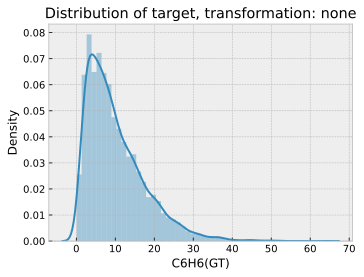

In [ ]:
plot_target_distribution(df['C6H6(GT)'], 'none')

We see that our target is right-skewed. Let's try to transform it in order to make the distribution closer to normal.

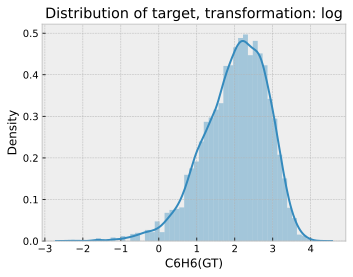

In [ ]:
plot_target_distribution(np.log(df['C6H6(GT)']), 'log')

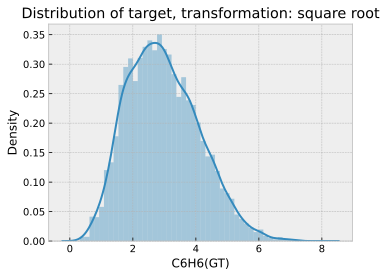

In [ ]:
plot_target_distribution(np.sqrt(df['C6H6(GT)']), 'square root')

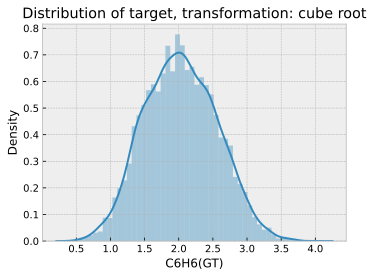

In [ ]:
plot_target_distribution(df['C6H6(GT)'] ** (1/3), 'cube root')

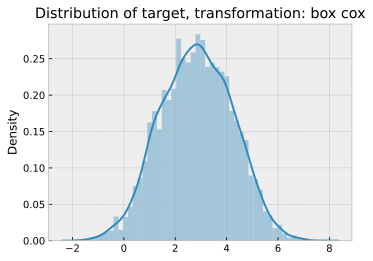

In [ ]:
plot_target_distribution(scipy.stats.boxcox(df['C6H6(GT)'])[0], 'box cox')

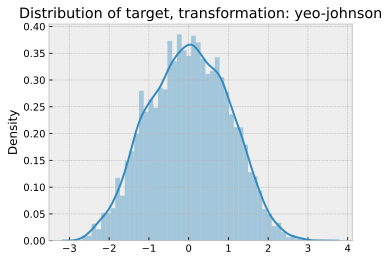

In [ ]:
plot_target_distribution(power_transform(df[['C6H6(GT)']], method='yeo-johnson'), 'yeo-johnson')

Box-cox transformation seems to give the best results. Let's make the skewtest. Null hypothesis $H_0$: the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution. The alternative hypothesis $H1$: the skewness of the population that the sample was taken differs from the skewness of the corresponding normal distribution. Let the significance level $\alpha$ be equal to 0.05.

In [ ]:
k2, p = scipy.stats.skewtest(scipy.stats.boxcox(df['C6H6(GT)'])[0])
p

0.3283423224067352

Since the p-value is bigger than 0.05, therefore null hypothesis is accepted.

Let's check if there are any negative target values to see if we can apply the box-cox transformation.

In [ ]:
len(df[df['C6H6(GT)'] < 0])

0

There are no negative values so we'll use the box-cox transformation for the target.

##Dealing with outliers

Let's look at the distributions of features and find their outliers.

CO(GT): lower limit: -1.8499999999999996, upper limit: 5.75, outliers: 186


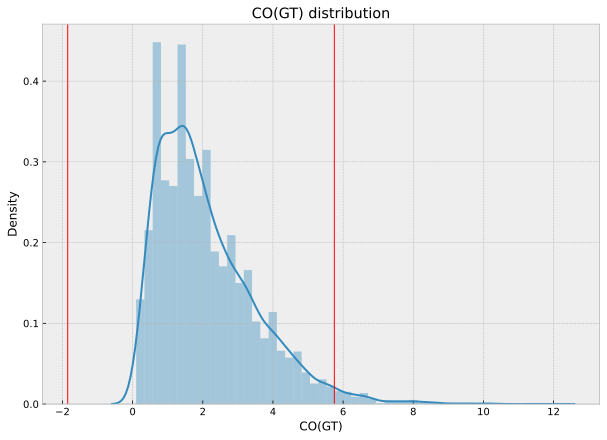

PT08.S1(CO): lower limit: 496.0, upper limit: 1672.0, outliers: 118


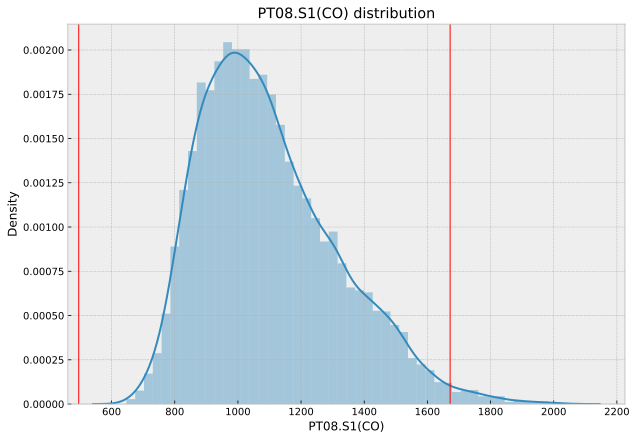

C6H6(GT): lower limit: -9.999999999999998, upper limit: 28.4, outliers: 228


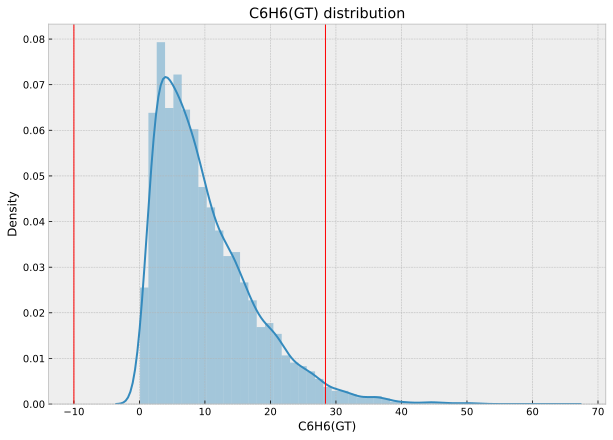

PT08.S2(NMHC): lower limit: 162.25, upper limit: 1688.25, outliers: 65


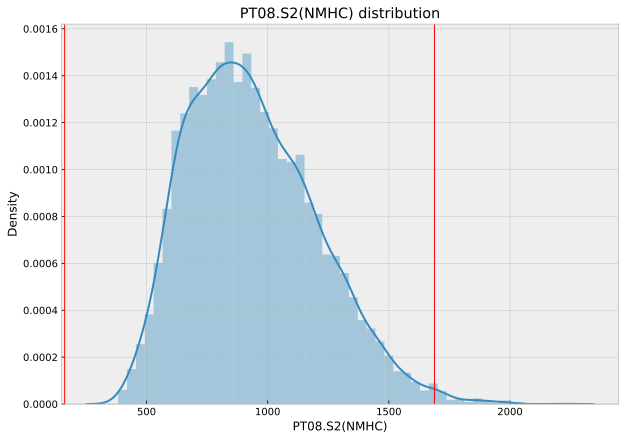

NOx(GT): lower limit: -245.5, upper limit: 662.5, outliers: 403


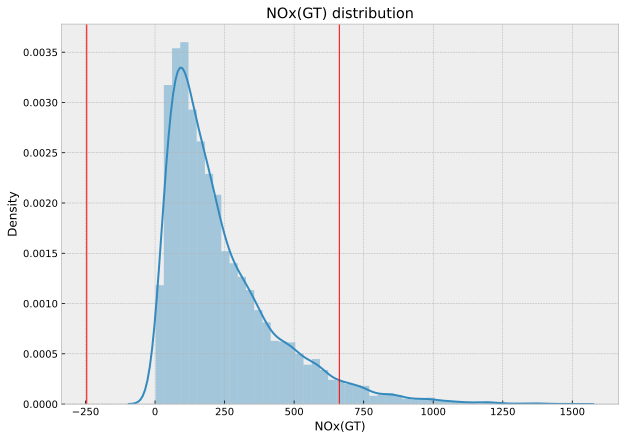

PT08.S3(NOx): lower limit: 190.75, upper limit: 1436.75, outliers: 241


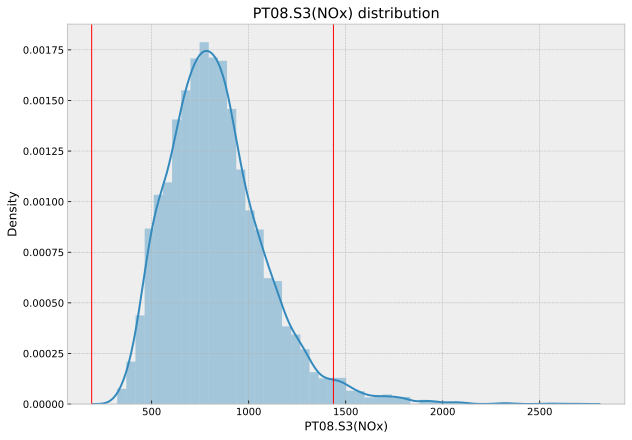

NO2(GT): lower limit: -15.0, upper limit: 225.0, outliers: 140


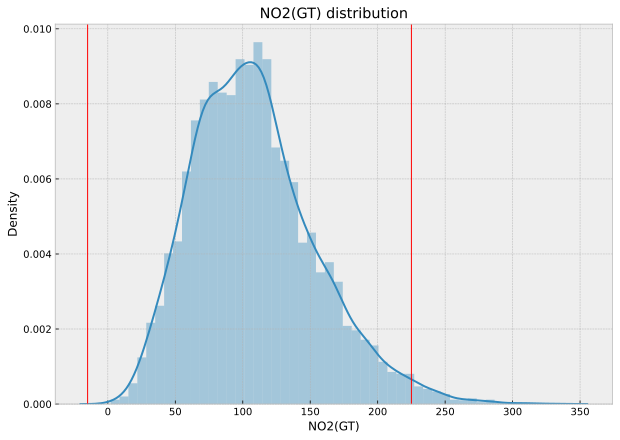

PT08.S4(NO2): lower limit: 556.5, upper limit: 2344.5, outliers: 97


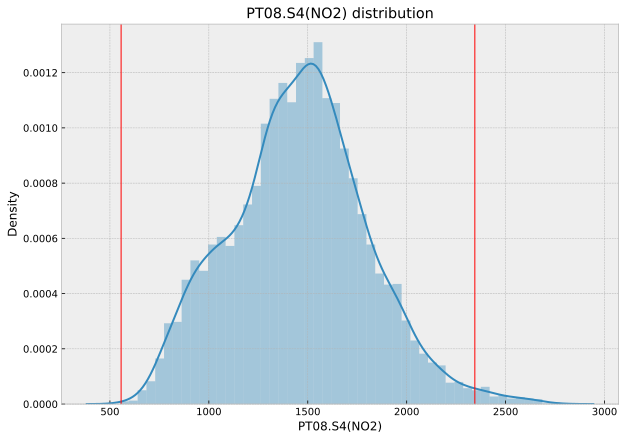

PT08.S5(O3): lower limit: -81.5, upper limit: 2086.5, outliers: 93


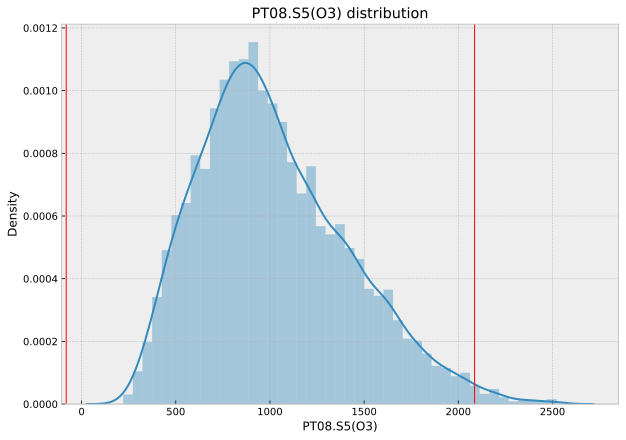

T: lower limit: -7.099999999999998, upper limit: 43.3, outliers: 3


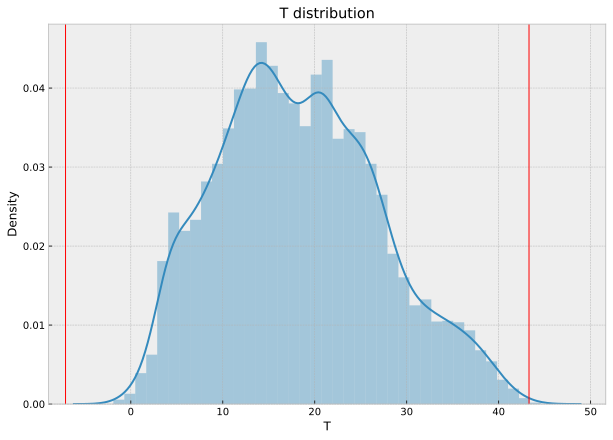

RH: lower limit: -4.250000000000007, upper limit: 102.55000000000001, outliers: 0


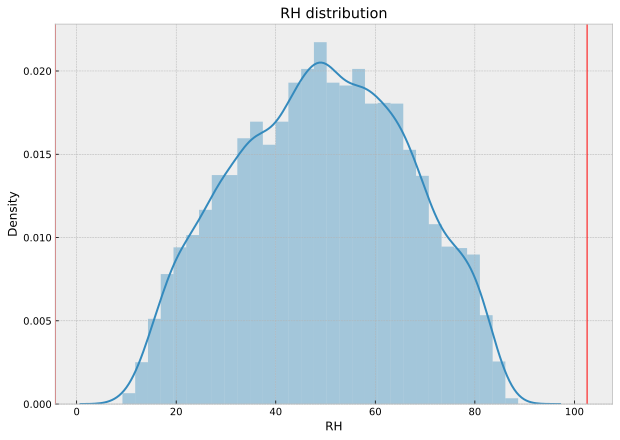

AH: lower limit: -0.12855000000000005, upper limit: 2.17905, outliers: 2


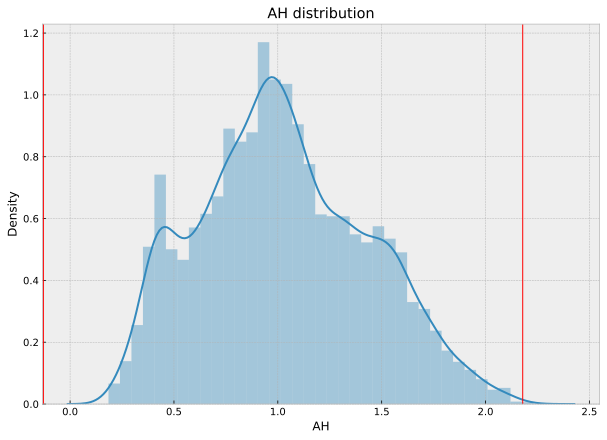

Day: lower limit: -16.0, upper limit: 48.0, outliers: 0


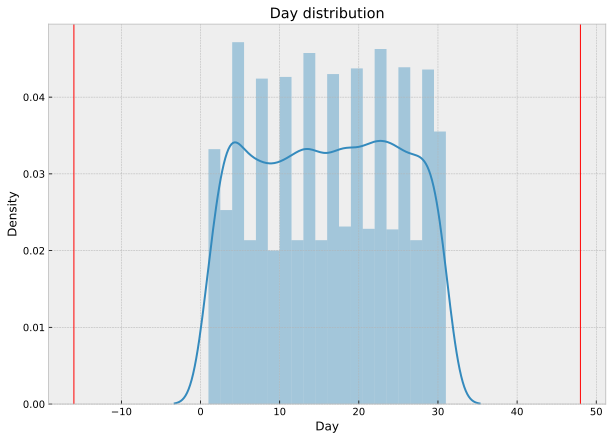

Month: lower limit: -6.0, upper limit: 18.0, outliers: 0


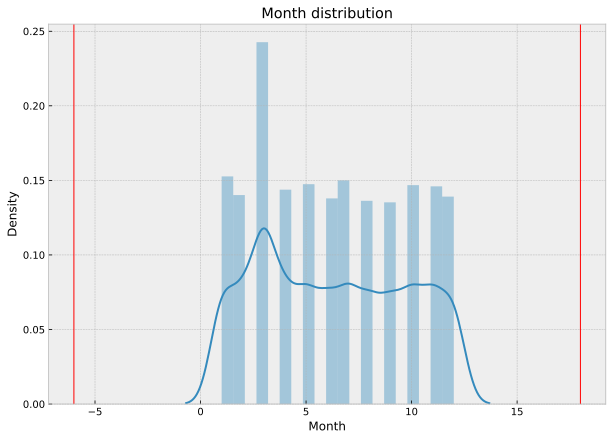

Year: lower limit: 2004.0, upper limit: 2004.0, outliers: 2109


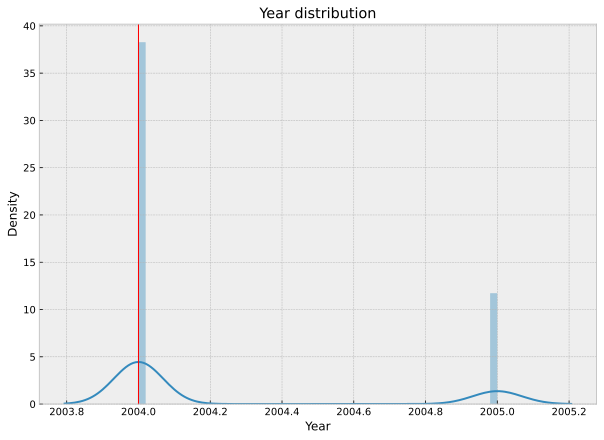

Hour: lower limit: -13.0, upper limit: 35.0, outliers: 0


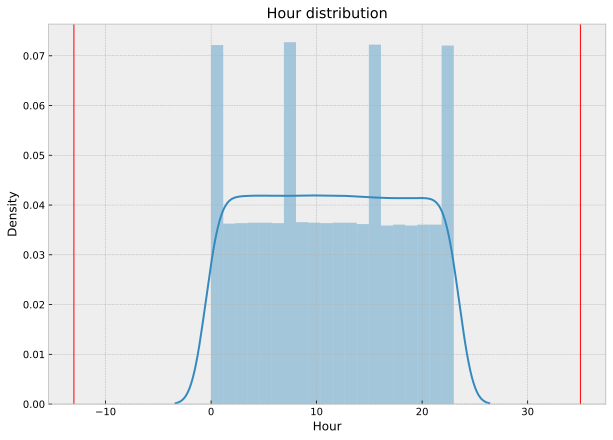

In [ ]:
for feature in df:
  lower_limit, upper_limit = find_limits(df[feature])
  print(f'{feature}: lower limit: {lower_limit}, upper limit: {upper_limit}, outliers: {len(find_outliers(df[feature], lower_limit, upper_limit))}')
  create_hist_with_outliers(df[feature], lower_limit, upper_limit)

We see most of the features are skewed and, accordingly, have outliers. To deal with this, I'd like to apply non-linear transformations and remove the rest of the outliers.

The `CO(GT)` feature is right-skewed and has 186 outliers. Let's try the cube root transformation.

Outliers: 10


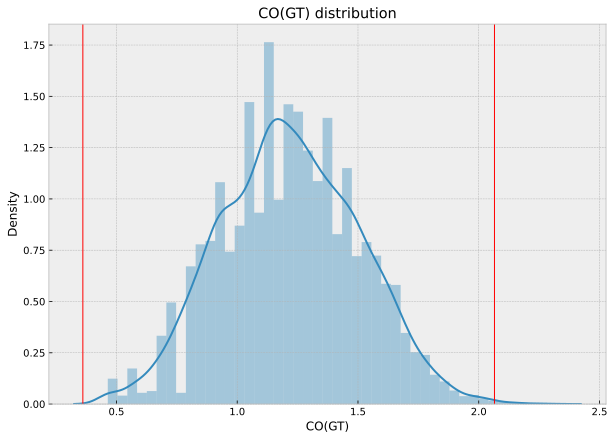

In [ ]:
  temp = (df['CO(GT)']) ** (1/3)
  lower_limit, upper_limit = find_limits(temp)
  h = find_outliers(temp, lower_limit, upper_limit)
  print(f'Outliers: {len(h)}')
  create_hist_with_outliers(temp, lower_limit, upper_limit)

We can see the number of the outliers is reduced. We can apply this transformation and drop the rest of the outliers.

In [ ]:
df_without_outliers = df.copy()

In [ ]:
df_without_outliers['CO(GT)'] = df_without_outliers['CO(GT)'] ** (1/3)
drop_outliers(df_without_outliers, 'CO(GT)', lower_limit, upper_limit)

We'll do the same with other features choosing the method that gives the least number of outliers.

In [ ]:
transform_and_drop_outliers(df_without_outliers, 'PT08.S1(CO)', 'log')
transform_and_drop_outliers(df_without_outliers, 'NOx(GT)', 'cube root')
transform_and_drop_outliers(df_without_outliers, 'PT08.S5(O3)', 'cube root')
transform_and_drop_outliers(df_without_outliers, 'PT08.S4(NO2)', 'sqrt')
transform_and_drop_outliers(df_without_outliers, 'PT08.S3(NOx)', 'log')
transform_and_drop_outliers(df_without_outliers, 'PT08.S2(NMHC)', 'log')

In [ ]:
transform_and_drop_outliers(df_without_outliers, 'C6H6(GT)', 'box-cox')

#Linear regression

## X and y datasets

Now we'll form the X and y datasets.

In [ ]:
features = df.select_dtypes(exclude=['category', 'object']).columns.tolist()
features.remove('C6H6(GT)')
features

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Day',
 'Month',
 'Year',
 'Hour']

In [ ]:
X = df_without_outliers[features]
y = df_without_outliers['C6H6(GT)']

Let's scale our features.

In [ ]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

##Multicollinearity (variance_inflation_factor)

Since there is multicollinearity in our dataset, we have to remove features that are highly correlated with each other in order to build a regression. I'll use `variance_inflation_factor` as a measure for multicollinearity.

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i)
                          for i in range(len(X_scaled.columns))]

vif_data

,feature,VIF
0,CO(GT),4.743841
1,PT08.S1(CO),8.525834
2,PT08.S2(NMHC),25.614738
3,NOx(GT),8.255626
4,PT08.S3(NOx),13.247959
5,NO2(GT),4.945570
6,PT08.S4(NO2),15.806558
7,PT08.S5(O3),8.681684
8,T,15.032464
9,RH,8.970716


According to documentation, if VIF is greater than 5, then the explanatory variable is highly collinear with the other explanatory variables. That's why we'll remove `PT08.S1(CO)`, `NOx(GT)	`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `RH` and `PT08.S5(O3)`.

In [ ]:
X_reduced_scaled = X_scaled.drop([1, 3, 4, 6, 7, 9], axis=1)

Also let's drop the features that have the least correlation with the target according to the correlation matrix received earlier.

In [ ]:
X_reduced_scaled.drop([11, 12, 13], axis=1 , inplace=True)

## Building a model

###Case 1 (transformed data, variance_inflation_factor)

Now let's try to build a linear regression. Since our data is time series and we can't assume the samples are independent and identically distributed, I'll use `TimeSeriesSplit` to split data samples.

Score:  0.99929407658724


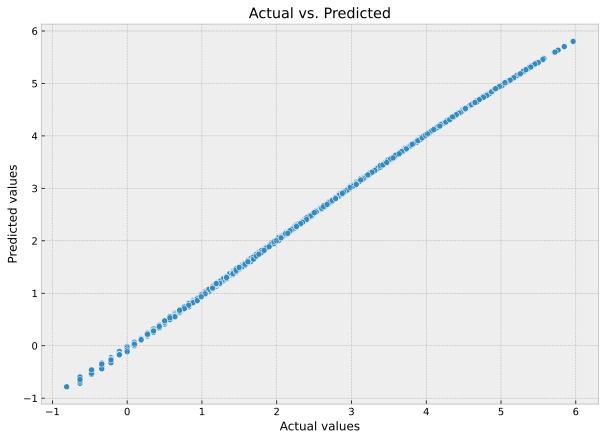

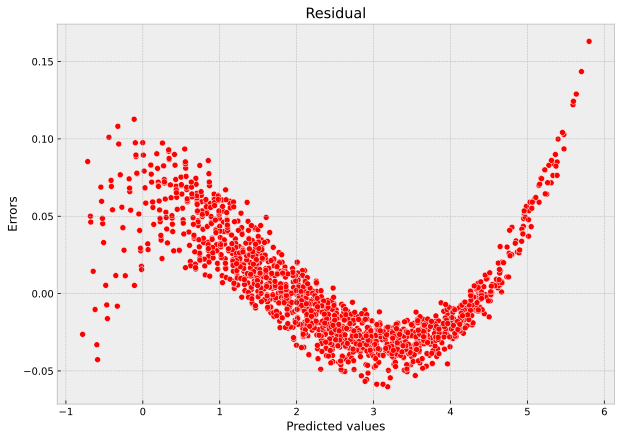

,0,1,2,3,4,5
MAE,0.024060,0.022266,0.033418,0.029710,0.028434,0.027578
MSE,0.001024,0.000908,0.002332,0.001370,0.001257,0.001378
R2,0.999312,0.999265,0.998927,0.999314,0.999294,0.999223
RMSE,0.032006,0.030140,0.048295,0.037007,0.035456,0.036581


In [ ]:
linreg = LinearRegression()
build_regression(linreg, X_reduced_scaled, y, n_splits=5)

The score of the model is 99.9%. All metrics are very close to their ideal values. The first plot shows there is almost no difference between predicted values and values from the dataset. The residual plot of errors has a high density of points close to the origin.

###Case 2 (transformed data, PCA)

Now let's try to use PCA in order to deal with multicollinearity. To extract features from the dataset using the PCA technique, firstly we need to find the percentage of variance explained as dimensionality decreases.

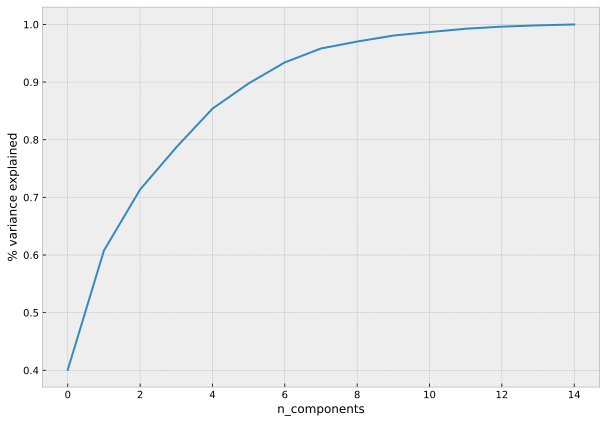

In [ ]:
def perform_pca(data, n_components):
  pca = PCA(n_components=n_components)
  pca_data = pd.DataFrame(pca.fit_transform(data))

  return pca, cumm_var_explained, pca_data


def show_pca(pca):
  percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
  cumm_var_explained = np.cumsum(percent_var_explained)

  plt.plot(cumm_var_explained)
  plt.xlabel('n_components')
  plt.ylabel('% variance explained')
  plt.show()


pca, cumm_var_explained, _ = perform_pca(X_scaled, X_scaled.shape[1])
show_pca(pca)

In [ ]:
cumm_var_explained

array([0.40081158, 0.60775712, 0.71357981, 0.78681439, 0.85393375,
       0.89771686, 0.93421146, 0.95833546, 0.97035052, 0.98073571,
       0.98686804, 0.99253842, 0.99623702, 0.99841633, 1.        ])

In [ ]:
pca.explained_variance_

array([6.01285791, 3.10453637, 1.58752103, 1.09864375, 1.0069049 ,
       0.65682138, 0.54748128, 0.36190131, 0.1802463 , 0.15579561,
       0.09199544, 0.08506543, 0.0554852 , 0.03269345, 0.02375773])

Since 98% of the total variance is captured by the 1st 10 PCA itself, we take 10 components of PCA and compute a correlation heatmap to overserve the multicollinearity.

In [ ]:
_, _, X_pca = perform_pca(X_scaled, 10)

print('Size: ', X_pca.shape)

X_pca.head()

Size:  (8788, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.119783,-0.162001,0.048480,1.016000,-1.449306,0.580289,1.652211,-0.894298,0.085334,0.819473
1,-0.065463,-0.247727,0.278254,1.041068,-1.466900,0.899014,1.668140,-0.997705,-0.094651,0.878611
2,0.518988,0.075613,0.018334,1.070009,-1.430259,1.093762,1.682679,-0.895883,0.210010,1.052543
3,0.870028,0.234544,-0.257757,1.099904,-1.412481,1.300971,1.604586,-0.806096,0.446207,0.871497
4,-0.039157,0.224996,-0.091278,1.149476,-1.434435,1.533388,1.500691,-0.834984,0.677234,0.827587


[Text(0.5, 1.0, 'Correlation after PCA')]

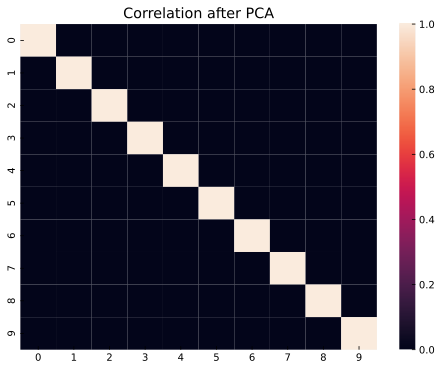

In [ ]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(X_pca.corr(),
            annot=False).set(title='Correlation after PCA')

From the above correlation heatmap, we see that none of the independent variables are now un-correlated. Let's build regression using `X_pca` data.

Score:  0.9632197592562547


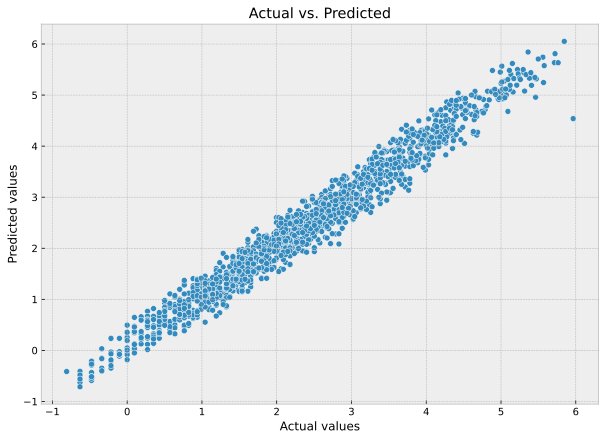

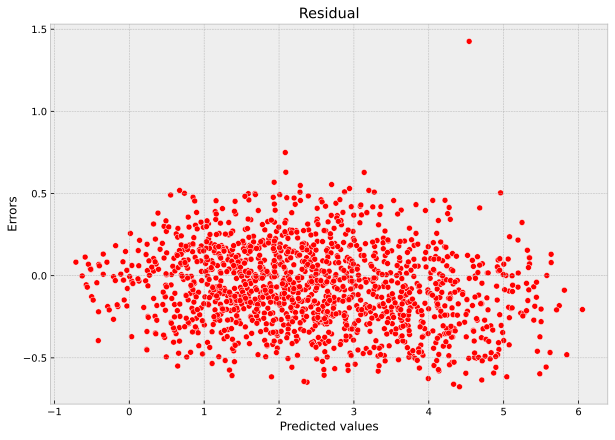

,0,1,2,3,4,5
MAE,0.194700,0.184362,0.206846,0.881595,0.206248,0.334750
MSE,0.063099,0.055425,0.069873,1.527102,0.065498,0.356199
R2,0.957640,0.955175,0.967862,0.234699,0.963220,0.815719
RMSE,0.251195,0.235426,0.264334,1.235760,0.255926,0.448528


In [ ]:
linreg = LinearRegression()
build_regression(linreg, X_pca, y, n_splits=5)

We got a score of 96.3% for our model. The first plot shows that predicted values and values from the dataset are close. The residual plot of errors has a high density of points close to the origin. It is also symmetric about the origin. There is probably one outlier. As for metrics, we see that the 3th iteration has the worst result. The average values of all metrics are good.

###Case 3 (data without transformation, PCA)

I'd like to try to build regression using PCA without feature transformation and see the results.

In [ ]:
X_try = df[features]
y_try = df['C6H6(GT)']

scaler = StandardScaler()
X_try = scaler.fit_transform(X_try)

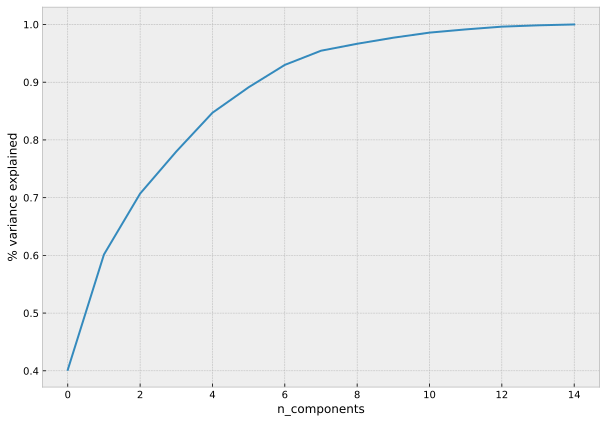

In [ ]:
pca_try, cumm_var_explained_try, _ = perform_pca(X_try, X_try.shape[1])
show_pca(pca_try)

In [ ]:
cumm_var_explained_try

array([0.40081158, 0.60775712, 0.71357981, 0.78681439, 0.85393375,
       0.89771686, 0.93421146, 0.95833546, 0.97035052, 0.98073571,
       0.98686804, 0.99253842, 0.99623702, 0.99841633, 1.        ])

In [ ]:
pca_try.explained_variance_

array([6.027212  , 2.99569029, 1.58307269, 1.09374307, 1.00743296,
       0.66250511, 0.58110407, 0.36829668, 0.18080806, 0.15765649,
       0.13207264, 0.08343878, 0.0715593 , 0.03455633, 0.02252006])

In [ ]:
_, _, X_pca_try = perform_pca(X_try, 10)

Score:  0.9260471136716215


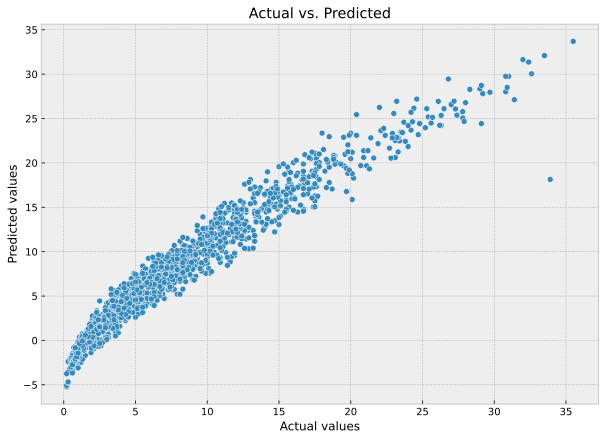

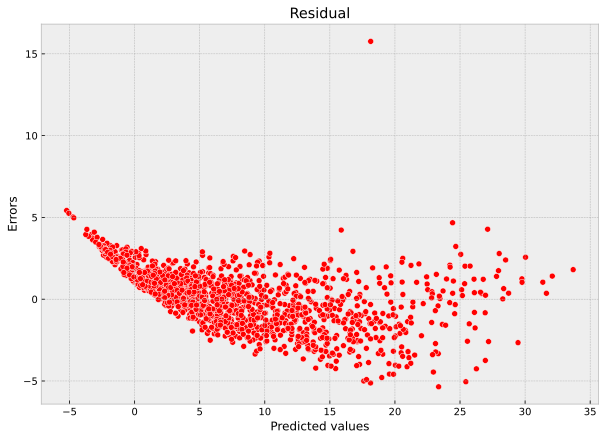

,0,1,2,3,4,5
MAE,0.887324,1.630804,2.112645,15.879550,1.353181,4.372701
MSE,1.381553,3.677389,6.780130,559.318284,2.928165,114.817104
R2,0.967883,0.886869,0.920206,-7.440835,0.926047,-0.747966
RMSE,1.175395,1.917652,2.603868,23.649911,1.711188,6.211603


In [ ]:
linreg = LinearRegression()
build_regression(linreg, X_pca_try, y_try, n_splits=5)

We can see that the results of this model are worse compared to the previous one.The residual plot of errors isn't symmetric and has bigger scatter. The 3th iteration still has the worst result.